<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [63]:
# загружаем библиотки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import warnings; warnings.filterwarnings(action='ignore') 
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
%pylab inline
pylab.rcParams['figure.figsize']=(18, 6)

Populating the interactive namespace from numpy and matplotlib


In [64]:
# откроем файл и посмотрим на данные
try:
    df = pd.read_csv('/datasets/taxi.csv')
except: 
    df = pd.read_csv('/Users/ASUS/Desktop/практикум/модуль 3/спринт12. Временные ряды/проект/taxi.csv')
display(df.tail(10))
display(df.info())
print('\n')
display(df.isna().sum())

,datetime,num_orders
26486,2018-08-31 22:20:00,48
26487,2018-08-31 22:30:00,41
26488,2018-08-31 22:40:00,34
26489,2018-08-31 22:50:00,34
26490,2018-08-31 23:00:00,30
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

datetime      0
num_orders    0
dtype: int64

In [65]:
# переведем даты в индекс и проверим их упорядоченность
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [66]:
# скомпилируем данные и посмотрим на статистику
df = df.resample('1H').sum()
print(df.shape)
display(df.describe())

(4416, 1)


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


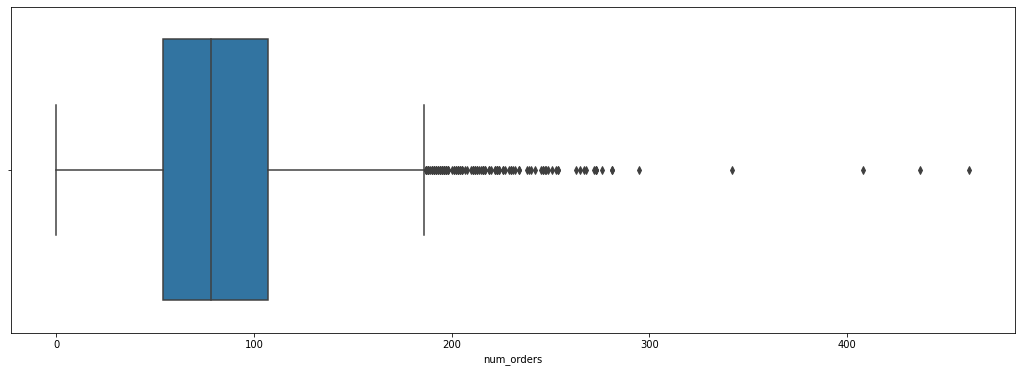

In [67]:
# выявим выбросы
sns.boxplot(x=df['num_orders'])
plt.show()

In [68]:
# скопируем датасет для декомпозиции, чтобы потом не обрабатывать получившиеся пропуски
df_1 = df.copy()

# найдем 5% и 95% квантили
print(df.quantile(0.95))
print(df.quantile(0.05))

num_orders    166.0
Name: 0.95, dtype: float64
num_orders    21.0
Name: 0.05, dtype: float64


In [69]:
# сгладим выбросы: присвоим значения 5% и 95% квантиля 
df = df.clip(21, 166)

## Анализ

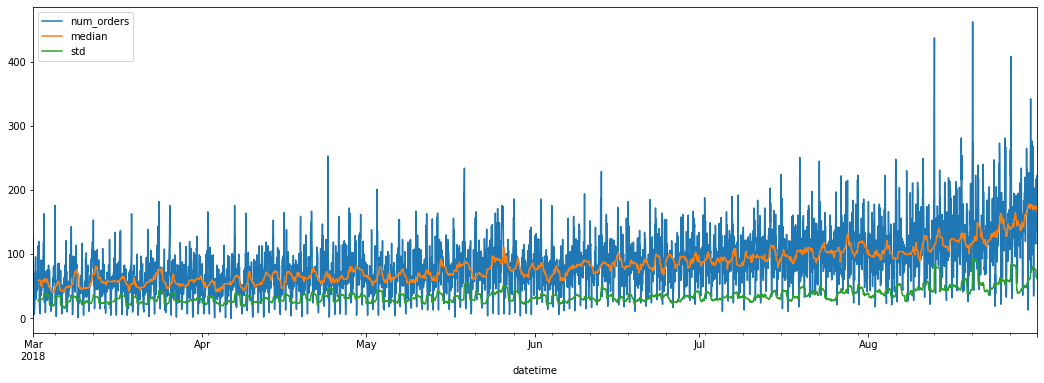

In [70]:
# визуализируем сырые данные. В качестве окна сглаживания возьмем сутки
df_1['median'] = df_1['num_orders'].rolling(24).median()
df_1['std'] =df_1['num_orders'].rolling(24).std()
df_1.plot()
plt.show()

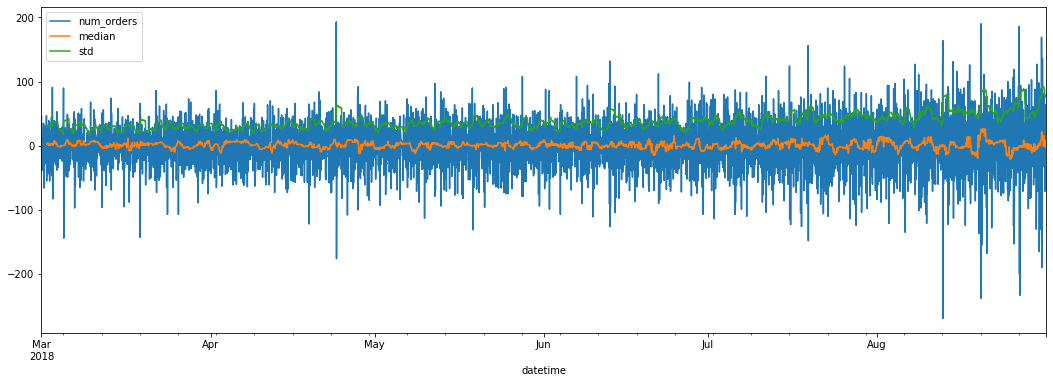

In [71]:
# визуализируем стационарный ряд
df_1 -= df_1.shift(fill_value=df_1['num_orders'].median())
df_1['median'] = df_1['num_orders'].rolling(24).median()
df_1['std'] =df_1['num_orders'].rolling(24).std()
df_1.plot()
plt.show()

данные стали более ровными, что позволяет нам в дальнейшем прогнозировать целевой признак

In [72]:
# посмотрим на период данных
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

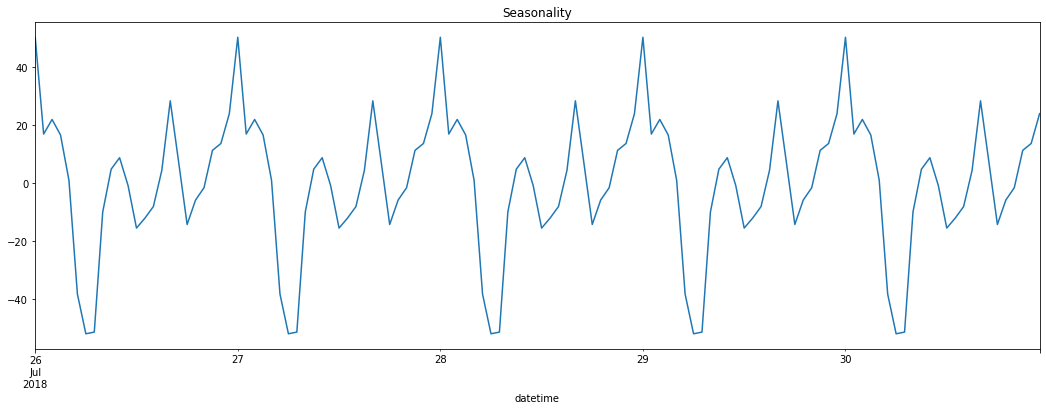

In [73]:
# т.к. нас интересует ежедневные пиковые нагрузки, поэтому выведем на экран только график периодичности данных за несколько дней
decomposed = seasonal_decompose(df)

decomposed.seasonal['2018-07-26 00:00:00':'2018-07-30 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

###  На графике четко видны 3 пика повышенного спроса: утром, после обеда и в вечернее время. Значит нам есть, что предсказывать.

## Обучение

In [74]:
# создадим таблицу, в которую будем складывать результаты
taxi_result = pd.DataFrame(columns=['Модель', 'RMSE'])
taxi_result

,Модель,RMSE


In [75]:
# создадим функцию, которая будет складывать результаты в таблицу
def taxi_metrics(df, rmse, model_name):
    df.loc[df.shape[0] + 1] = model_name, rmse
    return df

In [76]:
# создадим функцию, выделяющую признаки
def make_features(df, max_lag):
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

make_features(df, 4)

In [77]:
# проверка
display(df.head(6))

,num_orders,month,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,3,1,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,1,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,3,1,4,66.0,71.0,85.0,124.0
2018-03-01 05:00:00,21,3,3,1,5,43.0,66.0,71.0,85.0


In [78]:
# разобьем данные на обучающую и тестовую выборки, удалим образовавшиеся пропуски выборке
df = df.dropna()
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=1)
valid, test = train_test_split(test, test_size=0.5, shuffle=False, random_state=1)

In [79]:
#  выделим признаки и цель
y_train = train['num_orders']
y_test = test['num_orders']
y_valid = valid['num_orders']

x_train = train.drop('num_orders', axis=1)
x_test = test.drop('num_orders', axis=1)
x_valid = valid.drop('num_orders', axis=1)

In [80]:
# константная модель, заполненная медианой
const_pred = np.ones(valid.shape[0]) * y_train.median()
const_rmse = np.sqrt(mean_squared_error(const_pred, y_valid))
taxi_metrics(taxi_result, const_rmse, 'Константная модель')

,Модель,RMSE
1,Константная модель,51.082877


In [81]:
# модель сдвига
shift_pred = y_valid.shift()
shift_pred.iloc[0] = y_train.iloc[y_train.shape[0] - 1]
shift_rmse = np.sqrt(mean_squared_error(shift_pred, y_valid))
taxi_metrics(taxi_result, shift_rmse, 'Модель сдвига')

,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261


In [82]:
# линейная регрессия
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_valid)
lr_rmse = np.sqrt(mean_squared_error(lr_pred, y_valid))
taxi_metrics(taxi_result, lr_rmse, 'Линейная регрессия')

,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421


In [83]:
ridge = Ridge(alpha=1.0, random_state=1)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_valid)
ridge_rmse = np.sqrt(mean_squared_error(ridge_pred, y_valid))
taxi_metrics(taxi_result, ridge_rmse, 'Ridge регрессия')

,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746


In [84]:
lasso = Lasso(alpha=0.5, random_state=1)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_valid)
lasso_rmse = np.sqrt(mean_squared_error(lasso_pred, y_valid))
taxi_metrics(taxi_result, lasso_rmse, 'Lasso регрессия')

,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303


In [85]:
# модель решающего дерева
tree_depth = 0
tree_rmse = 100
for depth in range(1, 25):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    tree.fit(x_train, y_train)
    tree_pred = tree.predict(x_valid)
    result = np.sqrt(mean_squared_error(tree_pred, y_valid))
    
    
    if result < tree_rmse:
        tree_rmse = result
        tree_depth = depth

print('\n')
#print(tree_depth, tree_rmse)   
#print('\n')
taxi_metrics(taxi_result, tree_rmse, 'модель дерева')

,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303
6,модель дерева,28.182468


In [86]:

%%time
# модель случайного леса
f_depth = 0
f_estimators = 0
f_rmse = 100

for depth in range(1, 15):
    for estimator in range(10, 25):
        forest = RandomForestRegressor(n_estimators=estimator, max_depth=depth, bootstrap=False, random_state=1, n_jobs=-1)
        forest.fit(x_train, y_train)
        f_pred = forest.predict(x_valid)
        result = np.sqrt(mean_squared_error(f_pred, y_valid))
        
        if result < f_rmse:
            f_rmse = result
            f_depth = depth
            f_estimators = estimator

print(f'RMSE: {f_rmse}, глубина дерева {f_depth}, кол-во деревьев {f_estimators}.')
taxi_metrics(taxi_result, f_rmse, 'модель случайного леса')
#%%script false

RMSE: 28.069730437261754, глубина дерева 9, кол-во деревьев 19.
Wall time: 10.1 s


,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303
6,модель дерева,28.182468
7,модель случайного леса,28.069730


In [87]:

%%time
# определим лучшие параметры для модели LGBMRegressor
estimator = lgb.LGBMRegressor(random_state=1)
param_grid = {'num_leaves': [10, 11, 12, 13, 14, 15],
              'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 
              'n_estimators': [100, 110, 120, 130]}


gbm = GridSearchCV(estimator, param_grid, cv=TimeSeriesSplit())
gbm.fit(x_train, y_train)
print('Лучшие параметры сетки:', gbm.best_params_)
#%%script false

Лучшие параметры сетки: {'learning_rate': 0.07, 'n_estimators': 110, 'num_leaves': 13}
Wall time: 22.3 s


In [88]:

%%time
# используем LGBMRegressor с лучшими параметрами
gbm = lgb.LGBMRegressor(objective = 'regression', 
                        num_leaves = 13, 
                        learning_rate = 0.07,
                        max_depth = -1,
                        n_estimators = 110,
                        random_state=1)

gbm.fit(x_train, 
        y_train,
        eval_set = [(x_valid, y_valid)],
        eval_metric ='rmse',
        early_stopping_rounds = 5,
        verbose = 10)

lgb_pred = gbm.predict(x_valid,  num_iteration=gbm.best_iteration_)
lgb_rmse = np.sqrt(mean_squared_error(y_valid, lgb_pred))
print('\n')
print('Лучшая метрика:', lgb_rmse)
print('\n')


taxi_metrics(taxi_result, lgb_rmse, 'модель LightGBM')

Training until validation scores don't improve for 5 rounds
[10]	valid_0's rmse: 37.9688	valid_0's l2: 1441.63
[20]	valid_0's rmse: 33.0096	valid_0's l2: 1089.63
[30]	valid_0's rmse: 30.0845	valid_0's l2: 905.076
[40]	valid_0's rmse: 28.1917	valid_0's l2: 794.773
[50]	valid_0's rmse: 27.3185	valid_0's l2: 746.301
[60]	valid_0's rmse: 26.4658	valid_0's l2: 700.438
[70]	valid_0's rmse: 25.9997	valid_0's l2: 675.986
[80]	valid_0's rmse: 25.6428	valid_0's l2: 657.554
[90]	valid_0's rmse: 25.2621	valid_0's l2: 638.174
[100]	valid_0's rmse: 25.0304	valid_0's l2: 626.521
[110]	valid_0's rmse: 24.9212	valid_0's l2: 621.067
Did not meet early stopping. Best iteration is:
[108]	valid_0's rmse: 24.9143	valid_0's l2: 620.721


Лучшая метрика: 24.91428018165683


Wall time: 71 ms


,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303
6,модель дерева,28.182468
7,модель случайного леса,28.069730
8,модель LightGBM,24.914280


## Тестирование

In [89]:
%%script false
x_union = pd.concat([x_train, x_valid], axis=0)
y_union = pd.concat([y_train, y_valid], axis=0)

Couldn't find program: 'false'


In [92]:
# 
forest = RandomForestRegressor(n_estimators=19, max_depth=9, n_jobs=-1, random_state=1)
forest.fit(x_train, y_train)
test_f_pred = forest.predict(x_test)
test_result = np.sqrt(mean_squared_error(test_f_pred, y_test))


print(f'RMSE: {test_result}')        
taxi_metrics(taxi_result, test_result, 'test-модель леса')

RMSE: 38.68321351414871


,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303
6,модель дерева,28.182468
7,модель случайного леса,28.069730
8,модель LightGBM,24.914280
9,test-модель леса,38.596114
10,test-модель LightGBM,35.695510


In [91]:
#gbm = lgb.LGBMRegressor(objective = 'regression', 
#                        num_leaves = 13, 
#                        learning_rate = 0.07,
#                        max_depth = -1,
#                        n_estimators = 110, 
#                        random_state=1)

#gbm.fit(x_union, 
#        y_union,
#        eval_set = [(x_test, y_test)],
#        eval_metric ='rmse',
#        early_stopping_rounds = 5,
#        verbose = 10)

test_lgb_pred = gbm.predict(x_test,  num_iteration=gbm.best_iteration_)
test_lgb_rmse = np.sqrt(mean_squared_error(y_test, test_lgb_pred))
print('\n')
print('Лучшая метрика:', test_lgb_rmse)
taxi_metrics(taxi_result, test_lgb_rmse, 'test-модель LightGBM')



Лучшая метрика: 35.69550971980301


,Модель,RMSE
1,Константная модель,51.082877
2,Модель сдвига,38.306261
3,Линейная регрессия,33.090421
4,Ridge регрессия,33.090746
5,Lasso регрессия,33.195303
6,модель дерева,28.182468
7,модель случайного леса,28.069730
8,модель LightGBM,24.914280
9,test-модель леса,38.596114
10,test-модель LightGBM,35.695510


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48